In [2]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

african_isos = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI', 
    'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 
    'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 
    'TGO', 'UGA', 'ZMB', 'ZWE'
]

##### Figure out how much data is missing coordinates

In [3]:
global_dams = pd.read_csv(resolve_path(config['Global_Dam_Data_csv_path']))

africa_dams = global_dams[global_dams['ISO'].isin(african_isos)].copy()
africa_dams.to_csv(resolve_path(config['Africa_Dam_csv_path']))

# Ensure Long__res_ and Lat__res_ are treated as numeric
africa_dams.loc[:, 'Long__res_'] = pd.to_numeric(africa_dams['Long__res_'], errors='coerce')
africa_dams.loc[:, 'Lat__res_'] = pd.to_numeric(africa_dams['Lat__res_'], errors='coerce')

# Strip whitespace from ISO column just in case
africa_dams.loc[:, 'ISO'] = africa_dams['ISO'].str.strip()

# Check for rows where both Long__res_ and Lat__res_ are 0
zero_coords = (africa_dams['Long__res_'] == 0) & (africa_dams['Lat__res_'] == 0)

# Calculate the proportion
proportion_zeroes = zero_coords.sum() / len(africa_dams)

print(f"The proportion of data with null coordinates is {proportion_zeroes:.2%}")


The proportion of data with null coordinates is 24.65%


##### Turn the dam data into a gdf

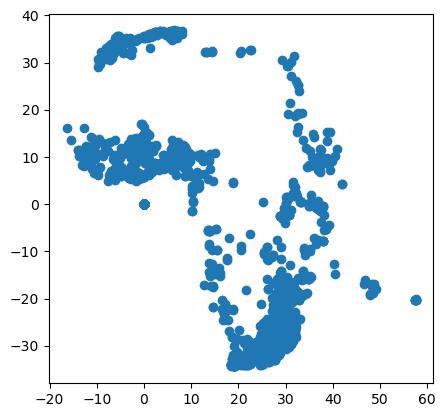

count    32364.000000
mean      4220.502742
std        409.566986
min       1153.010223
25%       4133.059613
50%       4293.381575
75%       4419.583090
max       5465.848190
Name: nearest_dam_distance, dtype: float64


In [4]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)

gdf_dams.plot()
plt.show()

# Load the CPIS shapefile
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both GeoDataFrames use the same CRS (unit in meters instead of degrees)
gdf_dams = gdf_dams.set_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: gdf_dams.distance(x).min())/1000

# Statistical summary of distances
distance_summary = gdf_cpis['nearest_dam_distance'].describe()
print(distance_summary)